In [1]:
"""
This notebook runs the CEBRA analyses on multiple sessions using reward labels.
Specifically, it runs the analysis on the data before the choice time and after the choice time
and then outputs a bargraph with reconstruction performance scores for these two periods for the ALL neuromodulators (there's a separate script that does it on individual neuromodulators).
"""

"\nThis notebook runs the CEBRA analyses on multiple sessions using reward labels.\nSpecifically, it runs the analysis on the data before the choice time and after the choice time\nand then outputs a bargraph with reconstruction performance scores for these two periods for the ALL neuromodulators (there's a separate script that does it on individual neuromodulators).\n"

In [2]:

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import utils

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from matplotlib.collections import LineCollection
import pandas as pd

## Load and format the Neuromodulator (NM) data and behavioural labels

In [3]:
# load the dataframe
df_trials_ses = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/df.pkl', "rb"))

In [4]:
# load the dictionary containing the traces
traces = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/traces.pkl', "rb"))

In [5]:
# load the trace times
trace_times = np.load('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/Trace times.npy', allow_pickle=True)

In [6]:
# Combine the traces for all NMs into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)

# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape

(218572, 4)

In [7]:
n_trials = 1765

In [8]:
# get the choice time 
choice_times = df_trials_ses['choice_time'][0:n_trials].to_numpy()

In [9]:
np.unique(np.isnan(choice_times),return_counts=True)[1][0]

1717

In [10]:
# Make a function to format the NM data into a 1s window around the choice

def format_data(neural_data, window=None ,df = df_trials_ses, trace_times_ = trace_times, choice_times_ = choice_times, window_size=10, n_trials=1765):

    # define the number of trials where the mouse made a choice
    n_choice_trials = np.unique(np.isnan(choice_times_),return_counts=True)[1][0]

    # list to hold all the 1s windows
    n_data_window = []

    # new trial label
    trial_labels = []

    # loop over all trials
    for i in range(0,n_trials):

        # skip trials where the animal didn't make a choice (null choice time)
        if np.isnan(choice_times_[i]):
            continue

        # find the index of the closest time to the choice time in the trace_times array 
        idx = np.abs(trace_times_ - choice_times_[i]).argmin()

        # take the previous 10 and/or the next 10 values of the NM data at these indices - 1s window
        if window =='before':
            n_data_window.append(neural_data[idx-10:idx])

        if window == 'after':
            n_data_window.append(neural_data[idx:idx+10])

        if window == None:
            n_data_window.append(neural_data[idx-10:idx+10])

        # label the timepoints as rewarded or unrewarded
        if df['reward'].iloc[i]:
            # new trial label
            trial_labels.append(1)

        elif df['reward'].iloc[i]==False:
            # new trial label
            trial_labels.append(0)


    # stack the nm data for each trial
    nms_HD = np.stack(n_data_window).reshape((n_choice_trials,-1))
    # format it into a tensor
    nms_HD = torch.from_numpy(nms_HD.astype(np.float64))
    print("neural tensor shape: ", nms_HD.shape)

    # convert trial labels into an array
    trial_labels = np.array(trial_labels)
    print("labels shape: ",trial_labels.shape)

    return nms_HD, trial_labels


In [11]:
all_nms_before, trial_labels_ = format_data(all_nms, window='before')

neural tensor shape:  torch.Size([1717, 40])
labels shape:  (1717,)


In [12]:
trial_labels_

array([1, 0, 0, ..., 1, 0, 0])

## Run analysis and compute embeddings on NM data BEFORE choice

In [14]:
rewarded, unrewarded = utils.define_label_classes(trial_labels=trial_labels_)

In [16]:
t_embed_b4, b_embed_b4 = utils.build_train_compute(all_nms_before, trial_labels_)

pos:  0.8318 neg:  4.0551 total:  4.8869 temperature:  1.0000: 100%|██████████| 2000/2000 [01:02<00:00, 32.21it/s]
pos:  0.1959 neg:  6.0134 total:  6.2093 temperature:  1.0000: 100%|██████████| 2000/2000 [01:05<00:00, 30.60it/s]


## Run analysis and compute embeddings on NM data AFTER choice

In [20]:
all_nms_af, trial_labels_af = format_data(all_nms, window='after')

neural tensor shape:  torch.Size([1717, 40])
labels shape:  (1717,)


In [21]:
t_embed_af, b_embed_af = utils.build_train_compute(all_nms_af, trial_labels_af)

pos:  1.0244 neg:  3.1200 total:  4.1444 temperature:  1.0000: 100%|██████████| 2000/2000 [01:16<00:00, 26.23it/s]
pos:  0.3099 neg:  5.5128 total:  5.8227 temperature:  1.0000: 100%|██████████| 2000/2000 [01:20<00:00, 24.98it/s]


In [22]:
two_embeddings = [b_embed_b4, b_embed_af]

## Quantify how well these embeddings show presence of reward

In [23]:
# define function to get the auc scores
def get_auc(set_of_embeddings,trial_labels, n_iterations=1):   

     # list to store mean auc scores at each of these embedding dimensions
    mean_scores = []
    errors = []

    for j, embedding in enumerate(set_of_embeddings):

        # quantify with AUC score
        scores = []

        # for each NM make a couple of runs of the log regression model to get error bars
        for i in range(n_iterations):

            # make logistic function, fit it and use it to predict the initial labels from the embedding
            logreg = LogisticRegression(random_state=42)
            logreg.fit(embedding, trial_labels)
            prediction = logreg.predict(embedding)

            # quantify how well the embedding mirrors the labels using the auc score

            # make a precision recall curve and get the threshold
            precision, recall, threshold = precision_recall_curve(trial_labels, prediction)
            threshold = np.concatenate([np.array([0]), threshold])

            # calculate the fpr and tpr for all thresholds of the classification
            fpr, tpr, threshold = roc_curve(trial_labels, prediction)

            # get the auc score and append it to the list
            roc_auc = auc(fpr, tpr)
            scores.append(roc_auc)

        # store the mean and the standard deviation 
        mean_scores.append(np.mean(scores))
        errors.append(np.std(scores))

    return mean_scores, errors

In [24]:
trial_labels_.shape

(1717,)

In [25]:
b_embed_af.shape

(1717, 3)

In [26]:
x_labels = ['Before choice', 'After Choice']

In [27]:
list_embeddings = [b_embed_b4, b_embed_af]

In [28]:
mean_scores, errors = get_auc(list_embeddings, trial_labels=trial_labels_)
scores_ = np.round(mean_scores,2)

In [29]:
x_labels

['Before choice', 'After Choice']

In [30]:
# first make function to make the plots given a list of embeddings
def plot4_embeddings(embeddings, labels = trial_labels_, l_class=[rewarded, unrewarded], titles=['DA (AUC:0.92)', 'NE (AUC:0.97)', '5HT (AUC:0.76)', 'ACh (AUC:0.85)']):

    # number of plots
    n_plots = len(embeddings)

    n_columns = 2
    n_rows = n_plots//n_columns

    # create axis
    fig = plt.figure(figsize=(10,4))
    gs = gridspec.GridSpec(n_rows, n_columns, figure=fig)

    # colour 
    c = ['cool','plasma','pink','winter']

    for i, embed in enumerate(embeddings):

        # create the axes
        ax = fig.add_subplot(gs[i // n_columns, i%n_columns], projection='3d')

        ax.set_xlabel("latent 1", labelpad=0.001, fontsize=13)
        ax.set_ylabel("latent 2", labelpad=0.001, fontsize=13)
        ax.set_zlabel("latent 3", labelpad=0.001, fontsize=13)

        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.zaxis.set_tick_params(labelright=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        # plot the embedding
        cebra.plot_embedding(embedding=embed[l_class[0],:], embedding_labels=labels[l_class[0]], ax=ax, markersize=2,title=titles[i], cmap=c[0])
        cebra.plot_embedding(embedding=embed[l_class[1],:], embedding_labels=labels[l_class[1]], ax=ax, markersize=2,title=titles[i], cmap=c[1])

    
    # Adjust the subplot layout manually
    #plt.subplots_adjust(left=0.1, right=0.55, top=0.95, bottom=0.05, wspace=0.0001)
    plt.suptitle("Embeddings of All Neuromodulators", fontsize=15)

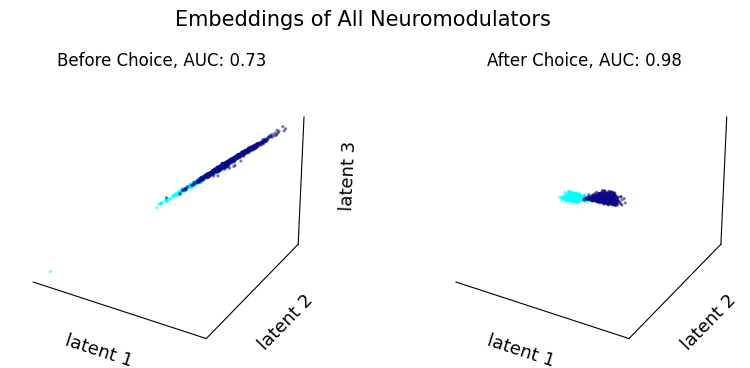

In [31]:
# plot both of them on one plot
plot4_embeddings(two_embeddings, labels=trial_labels_, l_class=[rewarded,unrewarded], titles=[f'Before Choice, AUC: {scores_[0]} ', f'After Choice, AUC: {scores_[1]} '])

Text(0.5, 1.0, 'AUC score (logistic regression) before and after choice')

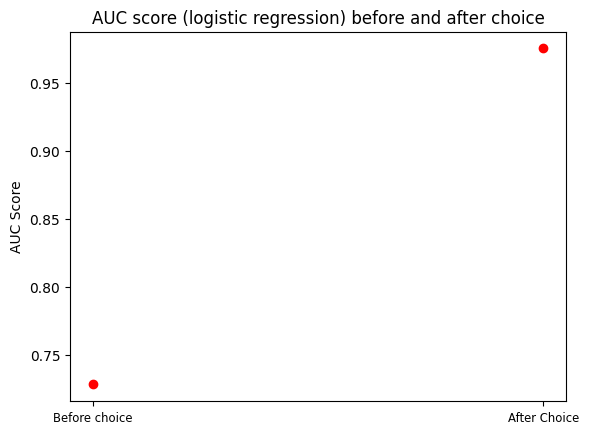

In [32]:
# print the auc score vs the embedding dimension
plt.errorbar(x=np.arange(0,2),y=mean_scores, yerr=errors, fmt='ro')
plt.xlabel("")
plt.xticks(range(len(x_labels)), x_labels, size='small')
plt.ylabel("AUC Score")
plt.title("AUC score (logistic regression) before and after choice")

In [33]:
labels = ['Before', 'After']

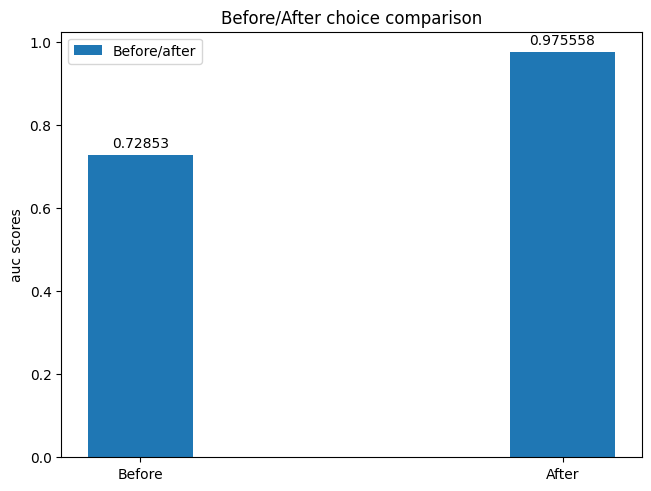

In [34]:
fig, ax = plt.subplots(layout='constrained')

x = np.arange(0,2)
width = 0.25


rects = ax.bar(x+width, mean_scores, width, label='Before/after')
ax.bar_label(rects, padding=3)

ax.set_ylabel('auc scores')
ax.set_title('Before/After choice comparison')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left')